# 1. Initialize

In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()


In [2]:
# Import the required modules
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.size'] = 8
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping


In [3]:
# Set all the related path
PATH_DATASET = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# 2. Prepare the data for training

In [24]:
# Image generator for training (include augmentation)
# we're not using rescaling, since EfficientNetB7 included rescaling in its bottom layer.
imgTrainGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 45,
    zoom_range = 0.2,
    shear_range = 0.2,
    featurewise_center = True,
    featurewise_std_normalization = True,
    width_shift_range = 0,
    height_shift_range = 0,
    vertical_flip = False,
    validation_split = 0.2,
    fill_mode = 'nearest'
)
# Image generator for testing (didn't include augmentation)
imgTestGen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.2
)

# Build the generator with flow from directory
# Build for training
trainGeneratorBuild = imgTrainGen.flow_from_directory(
    PATH_DATASET,
    subset = 'training',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32
)
# Build for test
testGeneratorBuild = imgTestGen.flow_from_directory(
    PATH_DATASET,
    subset = 'validation',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 1,shuffle=False
)

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


# 3. Create the Model

In [5]:
# Import the mobilenet pretrained base
pretrained_base = tf.keras.applications.efficientnet.EfficientNetB6(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224, 224, 3), pooling=None, classes=1000,
    classifier_activation='softmax'
)

# Freeze the pretrained base
pretrained_base.trainable = True;

model = tf.keras.Sequential([
    pretrained_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'), # This is our head
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

# Create our model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 7, 7, 2304)        40960143  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               295040    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 41,255,699
Trainable params: 295,556
Non-trainable params: 40,960,143
_________________________________________________________________


In [7]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics='accuracy'
)

# Training process. This sample only train for 5 Epochs
# Increase the training epoch for potentially better trainiing results
start = datetime.datetime.now()
history = model.fit(trainGeneratorBuild,
                    epochs = 1, 
                    validation_data = testGeneratorBuild,
                    verbose = 1)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

530/530 [==============================] - 287s 516ms/step - loss: 0.6137 - accuracy: 0.7672 - val_loss: 0.5006 - val_accuracy: 0.8084
Total Training Time: 0:04:47.847124


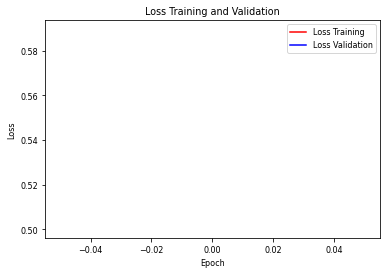

In [8]:
# Plotting training loss and validation loss
plt.plot(history.history['loss'], 'r', label='Loss Training')
plt.plot(history.history['val_loss'], 'b', label='Loss Validation')
plt.title('Loss Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [9]:
# Save the history as dataframe
history_df = pd.DataFrame(history.history)
history_df.to_csv('history.csv')

In [10]:
val_loss, val_acc = model.evaluate(testGeneratorBuild)


133/133 [==============================] - 22s 161ms/step - loss: 0.5006 - accuracy: 0.8084


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


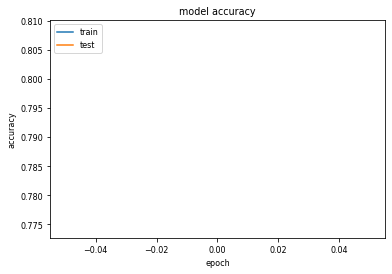

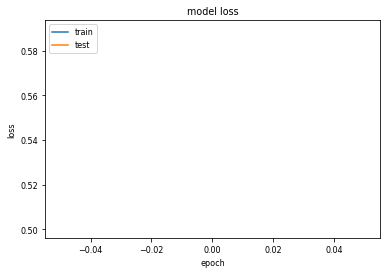

In [11]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
import numpy as np
from sklearn.utils.multiclass import unique_labels
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.utils import to_categorical
import random


In [ ]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
name = 'DenseNet_Pneumonia'
with open(name+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(name+".h5")
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv(name+'.csv',index = False)
hist_df.tail()


In [ ]:
json_file = open('./'+name+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./"+name+".h5")
print("Loaded model from disk")


In [ ]:
history_1= history

In [ ]:
def ModelGraphTrainngSummary(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy on Brain Tumor Classification")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Loss/Accuracy of "+model_name)
    matplotlib.pyplot.legend(loc="lower left")
    matplotlib.pyplot.savefig("plot.png")


In [ ]:
def ModelGraphTrainngSummaryAcc(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy on Brain Tumor Classification")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Accuracy of "+ model_name)
    matplotlib.pyplot.legend(loc="lower left")
    matplotlib.pyplot.savefig("plot.png")


In [14]:
from sklearn.metrics import classification_report


In [25]:
preds = model.predict(testGeneratorBuild)

preds_list = []

for pred in preds:
  preds_list.append(np.argmax(pred))

report = classification_report(testGeneratorBuild.classes, preds_list)

In [30]:
print(report)


              precision    recall  f1-score   support

           0       0.88      0.51      0.65       723
           1       0.84      0.74      0.79      1202
           2       0.77      0.97      0.86      2038
           3       0.94      0.67      0.79       269

    accuracy                           0.81      4232
   macro avg       0.86      0.72      0.77      4232
weighted avg       0.82      0.81      0.80      4232



In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import seaborn as sns

In [38]:
acc = accuracy_score(testGeneratorBuild.classes, preds_list)
precision = precision_score(testGeneratorBuild.classes, preds_list, average='macro')
recall = recall_score(testGeneratorBuild.classes, preds_list, average='macro')
f1 = f1_score(testGeneratorBuild.classes, preds_list, average='macro')
cm=confusion_matrix(testGeneratorBuild.classes, preds_list)

print('Accuracy\t: {:.2f} %'.format(acc * 100))
print('Precision\t: {:.2f} %'.format(precision * 100))
print('Recall\t\t: {:.2f} %'.format(recall * 100))
print('F1-Score\t: {:.2f} %'.format(f1 * 100))


Accuracy	: 80.84 %
Precision	: 86.02 %
Recall		: 72.44 %
F1-Score	: 77.07 %
[[ 371  120  231    1]
 [  40  890  272    0]
 [   9   40 1979   10]
 [   0    6   82  181]]


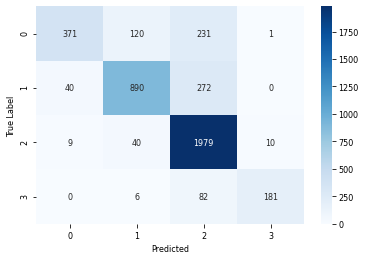

In [39]:
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()